In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from scipy.optimize import minimize
from scipy.stats import norm


In [2]:

class GPSinusoidalSampler:
    def __init__(self, bounds=(-2*np.pi, 2*np.pi), noise_level=0.1):
        """
        Initialize the GP sampler for a sinusoidal function.
        
        Args:
            bounds: tuple of (min, max) for the sampling domain
            noise_level: noise level for observations
        """
        self.bounds = bounds
        self.noise_level = noise_level
        
        # Define the true sinusoidal function
        self.true_function = lambda x: np.sin(x) + 0.5 * np.sin(3*x)
        
        # Initialize GP with RBF kernel
        kernel = C(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-2, 1e2))
        self.gp = GaussianProcessRegressor(
            kernel=kernel,
            alpha=noise_level**2,
            n_restarts_optimizer=10,
            random_state=42
        )
        
        # Storage for observations
        self.X_observed = np.array([]).reshape(0, 1)
        self.y_observed = np.array([])
        
    def sample_function(self, x):
        """Sample the true function with noise."""
        return self.true_function(x) + np.random.normal(0, self.noise_level, x.shape)
    
    def expected_improvement(self, X, xi=0.01):
        """
        Calculate Expected Improvement acquisition function.
        
        Args:
            X: points to evaluate
            xi: exploration parameter
        """
        if len(self.X_observed) == 0:
            return np.ones(X.shape[0])
        
        mu, sigma = self.gp.predict(X.reshape(-1, 1), return_std=True)
        mu = mu.flatten()
        sigma = sigma.flatten()
        
        # Current best observation
        f_best = np.max(self.y_observed)
        
        # Handle numerical stability
        sigma = np.maximum(sigma, 1e-9)
        
        # Calculate EI
        improvement = mu - f_best - xi
        Z = improvement / sigma
        ei = improvement * norm.cdf(Z) + sigma * norm.pdf(Z)
        
        return ei
    
    def upper_confidence_bound(self, X, kappa=2.0):
        """
        Calculate Upper Confidence Bound acquisition function.
        
        Args:
            X: points to evaluate
            kappa: exploration parameter
        """
        if len(self.X_observed) == 0:
            return np.ones(X.shape[0])
        
        mu, sigma = self.gp.predict(X.reshape(-1, 1), return_std=True)
        return mu.flatten() + kappa * sigma.flatten()
    
    def optimize_acquisition(self, acquisition_func='EI', n_restarts=10):
        """
        Find the point that maximizes the acquisition function.
        
        Args:
            acquisition_func: 'EI' for Expected Improvement or 'UCB' for Upper Confidence Bound
            n_restarts: number of random restarts for optimization
        """
        def objective(x):
            if acquisition_func == 'EI':
                return -self.expected_improvement(np.array([x]))[0]
            else:  # UCB
                return -self.upper_confidence_bound(np.array([x]))[0]
        
        best_x = None
        best_val = float('inf')
        
        # Try multiple random starting points
        for _ in range(n_restarts):
            x0 = np.random.uniform(self.bounds[0], self.bounds[1])
            result = minimize(objective, x0, bounds=[self.bounds], method='L-BFGS-B')
            
            if result.fun < best_val:
                best_val = result.fun
                best_x = result.x[0]
        
        return best_x
    
    def add_observation(self, x, y=None):
        """Add a new observation to the dataset."""
        if y is None:
            y = self.sample_function(np.array([x]))[0]
        
        self.X_observed = np.vstack([self.X_observed, [[x]]])
        self.y_observed = np.append(self.y_observed, y)
        
        # Refit the GP
        if len(self.X_observed) > 0:
            self.gp.fit(self.X_observed, self.y_observed)
    
    def run_optimization(self, n_iterations=10, acquisition_func='EI', initial_samples=3):
        """
        Run the complete optimization loop.
        
        Args:
            n_iterations: number of optimization iterations
            acquisition_func: 'EI' or 'UCB'
            initial_samples: number of random initial samples
        """
        print(f"Running GP optimization with {acquisition_func} acquisition function...")
        
        # Initial random sampling
        for i in range(initial_samples):
            x = np.random.uniform(self.bounds[0], self.bounds[1])
            self.add_observation(x)
            print(f"Initial sample {i+1}: x={x:.3f}, y={self.y_observed[-1]:.3f}")
        
        # Optimization loop
        for i in range(n_iterations):
            # Find next point to sample
            x_next = self.optimize_acquisition(acquisition_func)
            
            # Sample the function
            self.add_observation(x_next)
            
            print(f"Iteration {i+1}: x={x_next:.3f}, y={self.y_observed[-1]:.3f}")
        
        # Find the best observation
        best_idx = np.argmax(self.y_observed)
        best_x = self.X_observed[best_idx, 0]
        best_y = self.y_observed[best_idx]
        
        print(f"\nBest found: x={best_x:.3f}, y={best_y:.3f}")
        print(f"True optimum: x={np.pi/2:.3f}, y={self.true_function(np.pi/2):.3f}")
    
    def plot_results(self, acquisition_func='EI'):
        """Plot the GP model, observations, and acquisition function."""
        if len(self.X_observed) == 0:
            print("No observations to plot!")
            return
        
        # Create test points
        X_test = np.linspace(self.bounds[0], self.bounds[1], 200).reshape(-1, 1)
        y_true = self.true_function(X_test.flatten())
        
        # GP predictions
        y_pred, y_std = self.gp.predict(X_test, return_std=True)
        
        # Acquisition function values
        if acquisition_func == 'EI':
            acq_values = self.expected_improvement(X_test.flatten())
            acq_name = "Expected Improvement"
        else:
            acq_values = self.upper_confidence_bound(X_test.flatten())
            acq_name = "Upper Confidence Bound"
        
        # Create plots
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
        
        # Plot 1: GP model and observations
        ax1.plot(X_test.flatten(), y_true, 'r--', label='True function', alpha=0.7)
        ax1.plot(X_test.flatten(), y_pred, 'b-', label='GP mean', linewidth=2)
        ax1.fill_between(X_test.flatten(), y_pred - 2*y_std, y_pred + 2*y_std,
                        alpha=0.3, color='blue', label='GP uncertainty (±2σ)')
        ax1.scatter(self.X_observed.flatten(), self.y_observed, 
                   c='red', s=50, zorder=5, label='Observations')
        
        # Highlight the best observation
        best_idx = np.argmax(self.y_observed)
        ax1.scatter(self.X_observed[best_idx], self.y_observed[best_idx],
                   c='gold', s=100, marker='*', zorder=6, label='Best observation')
        
        ax1.set_xlabel('x')
        ax1.set_ylabel('y')
        ax1.set_title('Gaussian Process Regression')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Plot 2: Acquisition function
        ax2.plot(X_test.flatten(), acq_values, 'g-', linewidth=2)
        ax2.set_xlabel('x')
        ax2.set_ylabel(acq_name)
        ax2.set_title(f'{acq_name} Acquisition Function')
        ax2.grid(True, alpha=0.3)
        
        # Mark the next suggested point
        if len(acq_values) > 0:
            next_x = X_test.flatten()[np.argmax(acq_values)]
            ax2.axvline(x=next_x, color='red', linestyle='--', alpha=0.7, 
                       label='Next suggested point')
            ax2.legend()
        
        plt.tight_layout()
        plt.show()



EXPECTED IMPROVEMENT
Running GP optimization with EI acquisition function...
Initial sample 1: x=-11.595, y=1.091
Initial sample 2: x=5.501, y=-1.150
Initial sample 3: x=-7.050, y=-1.188
Iteration 1: x=-2.726, y=-0.763
Iteration 2: x=-10.528, y=0.749
Iteration 3: x=12.566, y=-0.172
Iteration 4: x=-12.566, y=0.136
Iteration 5: x=1.334, y=0.523
Iteration 6: x=-11.256, y=0.721
Iteration 7: x=2.134, y=0.829
Iteration 8: x=0.157, y=0.316
Iteration 9: x=-0.877, y=-1.041
Iteration 10: x=-11.843, y=1.097
Iteration 11: x=-9.790, y=0.738
Iteration 12: x=2.937, y=0.577
Iteration 13: x=9.277, y=0.256
Iteration 14: x=7.997, y=0.590
Iteration 15: x=10.678, y=-0.675
Iteration 16: x=7.185, y=0.996
Iteration 17: x=-4.827, y=0.612
Iteration 18: x=-4.127, y=0.990
Iteration 19: x=-11.799, y=1.061
Iteration 20: x=-8.782, y=-0.892
Iteration 21: x=6.797, y=1.068
Iteration 22: x=3.894, y=-1.004
Iteration 23: x=6.939, y=0.996
Iteration 24: x=-4.325, y=0.857
Iteration 25: x=7.048, y=1.199
Iteration 26: x=11.715

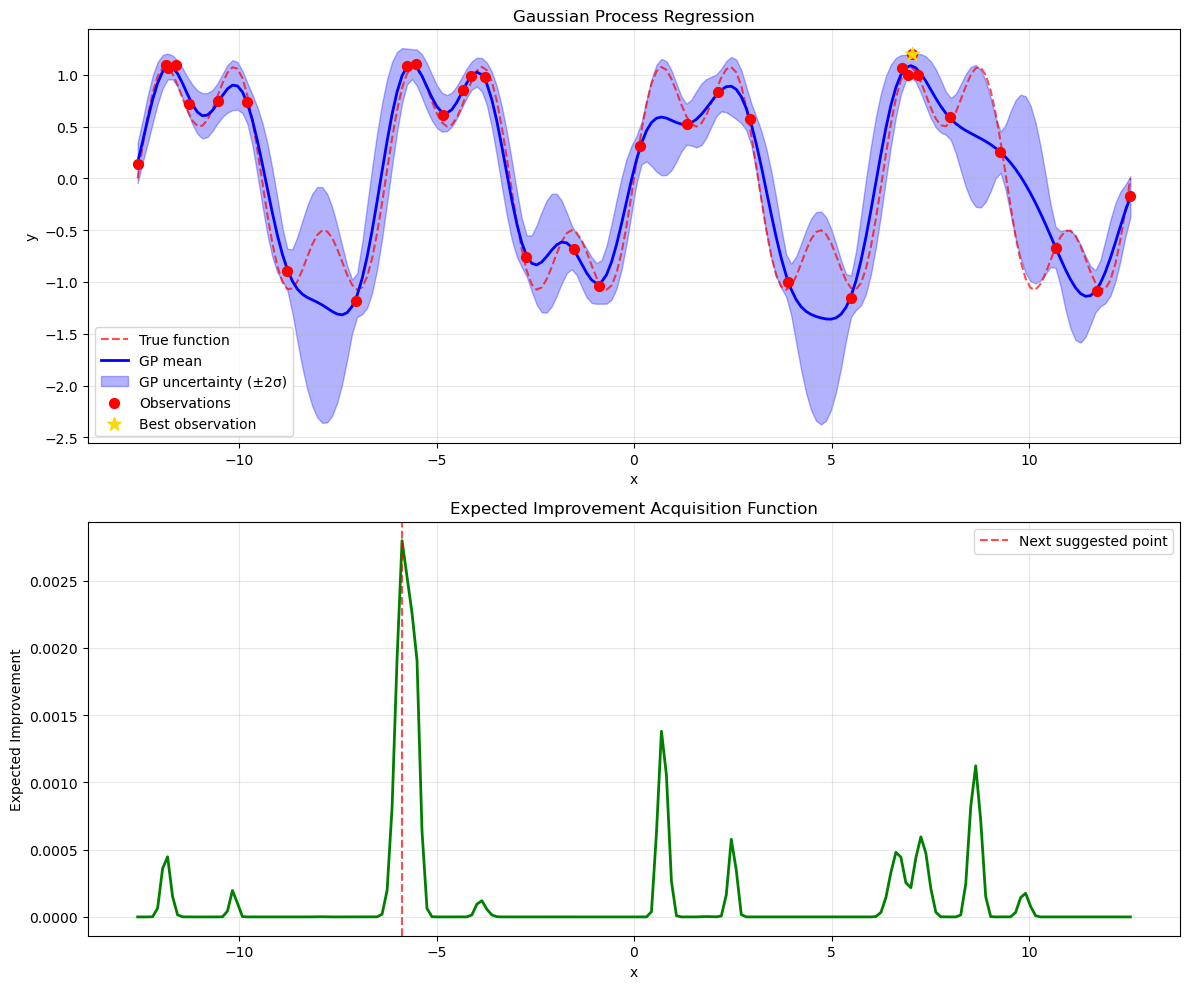


UPPER CONFIDENCE BOUND
Running GP optimization with UCB acquisition function...
Initial sample 1: x=-11.910, y=1.061
Initial sample 2: x=-5.920, y=0.731
Initial sample 3: x=0.134, y=0.406
Iteration 1: x=-12.566, y=0.246
Iteration 2: x=-11.431, y=0.851
Iteration 3: x=-6.680, y=-0.822
Iteration 4: x=0.849, y=1.115
Iteration 5: x=1.421, y=0.454
Iteration 6: x=-5.324, y=0.934
Iteration 7: x=-4.376, y=0.621
Iteration 8: x=-3.464, y=0.675
Iteration 9: x=-2.552, y=-0.946
Iteration 10: x=-10.071, y=1.224
Iteration 11: x=-9.458, y=0.117
Iteration 12: x=-10.554, y=0.717
Iteration 13: x=6.439, y=0.270
Iteration 14: x=5.464, y=-1.000
Iteration 15: x=9.137, y=0.594
Iteration 16: x=8.403, y=0.913
Iteration 17: x=11.927, y=-1.080
Iteration 18: x=7.635, y=0.623
Iteration 19: x=3.342, y=-0.485
Iteration 20: x=-3.881, y=1.084
Iteration 21: x=10.152, y=-1.245
Iteration 22: x=8.727, y=0.958
Iteration 23: x=-1.081, y=-0.773
Iteration 24: x=-10.085, y=1.048
Iteration 25: x=0.687, y=1.005
Iteration 26: x=7.

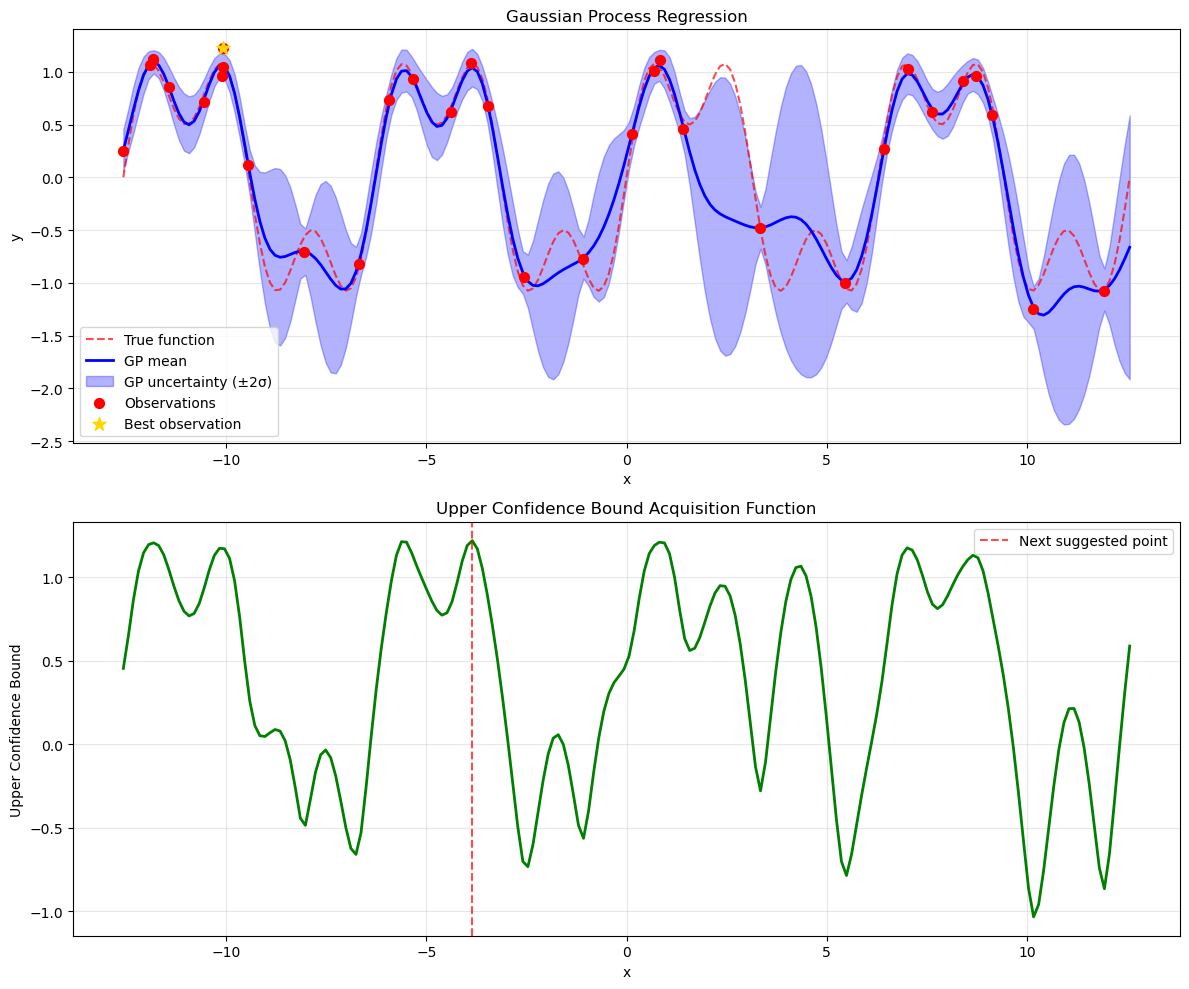

In [3]:
# Example usage
if __name__ == "__main__":
    # Create the sampler
    sampler = GPSinusoidalSampler(bounds=(-4*np.pi, 4*np.pi), noise_level=0.1)
    
    # Run optimization with Expected Improvement
    print("=" * 50)
    print("EXPECTED IMPROVEMENT")
    print("=" * 50)
    sampler.run_optimization(n_iterations=30, acquisition_func='EI', initial_samples=3)
    sampler.plot_results(acquisition_func='EI')
    
    # Reset and try with Upper Confidence Bound
    sampler_ucb = GPSinusoidalSampler(bounds=(-4*np.pi, 4*np.pi), noise_level=0.1)
    print("\n" + "=" * 50)
    print("UPPER CONFIDENCE BOUND")
    print("=" * 50)
    sampler_ucb.run_optimization(n_iterations=30, acquisition_func='UCB', initial_samples=3)
    sampler_ucb.plot_results(acquisition_func='UCB')

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from scipy.optimize import minimize
from scipy.stats import norm

class GPSinusoidalSampler:
    def __init__(self, bounds=(-2*np.pi, 2*np.pi), noise_level=0.1):
        """
        Initialize the GP sampler for a sinusoidal function.
        
        Args:
            bounds: tuple of (min, max) for the sampling domain
            noise_level: noise level for observations
        """
        self.bounds = bounds
        self.noise_level = noise_level
        
        # Define the true sinusoidal function
        self.true_function = lambda x: np.sin(x) + 0.5 * np.sin(3*x)
        
        # Initialize GP with RBF kernel
        kernel = C(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-2, 1e2))
        self.gp = GaussianProcessRegressor(
            kernel=kernel,
            alpha=noise_level**2,
            n_restarts_optimizer=10,
            random_state=42
        )
        
        # Storage for observations
        self.X_observed = np.array([]).reshape(0, 1)
        self.y_observed = np.array([])
        
    def sample_function(self, x):
        """Sample the true function with noise."""
        return self.true_function(x) + np.random.normal(0, self.noise_level, x.shape)
    
    def sample_density_weight(self, X, bandwidth=0.5):
        """
        Calculate sample density weights - higher weights for lower density areas.
        
        Args:
            X: points to evaluate
            bandwidth: bandwidth for density estimation
        """
        if len(self.X_observed) == 0:
            return np.ones(X.shape[0])
        
        # Calculate distance-based density for each point
        weights = np.ones(X.shape[0])
        
        for i, x in enumerate(X):
            # Calculate distances to all observed points
            distances = np.abs(self.X_observed.flatten() - x)
            
            # Use exponential decay to weight nearby samples more heavily
            density = np.sum(np.exp(-distances**2 / (2 * bandwidth**2)))
            
            # Invert density to prioritize low-density areas
            weights[i] = 1.0 / (1.0 + density)
        
        return weights
    
    def uncertainty_exploration(self, X, density_weight=0.7, uncertainty_weight=0.3):
        """
        Pure uncertainty-based exploration with sample density weighting.
        
        Args:
            X: points to evaluate
            density_weight: weight for sample density component
            uncertainty_weight: weight for GP uncertainty component
        """
        if len(self.X_observed) == 0:
            return np.ones(X.shape[0])
        
        # Get GP uncertainty (standard deviation)
        _, sigma = self.gp.predict(X.reshape(-1, 1), return_std=True)
        sigma = sigma.flatten()
        
        # Get sample density weights
        density_weights = self.sample_density_weight(X)
        
        # Normalize both components
        sigma_norm = sigma / (np.max(sigma) + 1e-9)
        density_norm = density_weights / (np.max(density_weights) + 1e-9)
        
        # Combine uncertainty and density
        acquisition = uncertainty_weight * sigma_norm + density_weight * density_norm
        
        return acquisition
    
    def expected_improvement(self, X, xi=0.01, density_boost=2.0):
        """
        Enhanced Expected Improvement with sample density weighting.
        
        Args:
            X: points to evaluate
            xi: exploration parameter
            density_boost: multiplier for low-density areas
        """
        if len(self.X_observed) == 0:
            return np.ones(X.shape[0])
        
        mu, sigma = self.gp.predict(X.reshape(-1, 1), return_std=True)
        mu = mu.flatten()
        sigma = sigma.flatten()
        
        # Current best observation
        f_best = np.max(self.y_observed)
        
        # Handle numerical stability
        sigma = np.maximum(sigma, 1e-9)
        
        # Calculate standard EI
        improvement = mu - f_best - xi
        Z = improvement / sigma
        ei = improvement * norm.cdf(Z) + sigma * norm.pdf(Z)
        
        # Add sample density weighting
        density_weights = self.sample_density_weight(X)
        
        # Boost EI in low-density areas
        ei_enhanced = ei * (1.0 + density_boost * density_weights)
        
        return ei_enhanced
    
    def upper_confidence_bound(self, X, kappa=2.0, density_boost=1.5):
        """
        Enhanced Upper Confidence Bound with sample density weighting.
        
        Args:
            X: points to evaluate
            kappa: exploration parameter
            density_boost: multiplier for low-density areas
        """
        if len(self.X_observed) == 0:
            return np.ones(X.shape[0])
        
        mu, sigma = self.gp.predict(X.reshape(-1, 1), return_std=True)
        ucb = mu.flatten() + kappa * sigma.flatten()
        
        # Add sample density weighting
        density_weights = self.sample_density_weight(X)
        
        # Boost UCB in low-density areas
        ucb_enhanced = ucb + density_boost * sigma.flatten() * density_weights
        
        return ucb_enhanced
    
    def optimize_acquisition(self, acquisition_func='EI', n_restarts=10):
        """
        Find the point that maximizes the acquisition function.
        
        Args:
            acquisition_func: 'EI', 'UCB', or 'UE' (Uncertainty Exploration)
            n_restarts: number of random restarts for optimization
        """
        def objective(x):
            if acquisition_func == 'EI':
                return -self.expected_improvement(np.array([x]))[0]
            elif acquisition_func == 'UCB':
                return -self.upper_confidence_bound(np.array([x]))[0]
            else:  # UE - Uncertainty Exploration
                return -self.uncertainty_exploration(np.array([x]))[0]
        
        best_x = None
        best_val = float('inf')
        
        # Try multiple random starting points
        for _ in range(n_restarts):
            x0 = np.random.uniform(self.bounds[0], self.bounds[1])
            result = minimize(objective, x0, bounds=[self.bounds], method='L-BFGS-B')
            
            if result.fun < best_val:
                best_val = result.fun
                best_x = result.x[0]
        
        return best_x
    
    def add_observation(self, x, y=None):
        """Add a new observation to the dataset."""
        if y is None:
            y = self.sample_function(np.array([x]))[0]
        
        self.X_observed = np.vstack([self.X_observed, [[x]]])
        self.y_observed = np.append(self.y_observed, y)
        
        # Refit the GP
        if len(self.X_observed) > 0:
            self.gp.fit(self.X_observed, self.y_observed)
    
    def run_optimization(self, n_iterations=10, acquisition_func='EI', initial_samples=3):
        """
        Run the complete optimization loop.
        
        Args:
            n_iterations: number of optimization iterations
            acquisition_func: 'EI', 'UCB', or 'UE' (Uncertainty Exploration)
            initial_samples: number of random initial samples
        """
        print(f"Running GP optimization with {acquisition_func} acquisition function...")
        print("Enhanced with uncertainty and sample density prioritization")
        
        # Initial random sampling
        for i in range(initial_samples):
            x = np.random.uniform(self.bounds[0], self.bounds[1])
            self.add_observation(x)
            print(f"Initial sample {i+1}: x={x:.3f}, y={self.y_observed[-1]:.3f}")
        
        # Optimization loop
        for i in range(n_iterations):
            # Find next point to sample
            x_next = self.optimize_acquisition(acquisition_func)
            
            # Sample the function
            self.add_observation(x_next)
            
            print(f"Iteration {i+1}: x={x_next:.3f}, y={self.y_observed[-1]:.3f}")
        
        # Find the best observation
        best_idx = np.argmax(self.y_observed)
        best_x = self.X_observed[best_idx, 0]
        best_y = self.y_observed[best_idx]
        
        print(f"\nBest found: x={best_x:.3f}, y={best_y:.3f}")
        print(f"True optimum: x={np.pi/2:.3f}, y={self.true_function(np.pi/2):.3f}")
    
    def plot_results(self, acquisition_func='EI'):
        """Plot the GP model, observations, acquisition function, and sample density."""
        if len(self.X_observed) == 0:
            print("No observations to plot!")
            return
        
        # Create test points
        X_test = np.linspace(self.bounds[0], self.bounds[1], 200).reshape(-1, 1)
        y_true = self.true_function(X_test.flatten())
        
        # GP predictions
        y_pred, y_std = self.gp.predict(X_test, return_std=True)
        print("Y predict : ", y_pred)
        
        # Acquisition function values
        if acquisition_func == 'EI':
            acq_values = self.expected_improvement(X_test.flatten())
            acq_name = "Enhanced Expected Improvement"
        elif acquisition_func == 'UCB':
            acq_values = self.upper_confidence_bound(X_test.flatten())
            acq_name = "Enhanced Upper Confidence Bound"
        else:  # UE
            acq_values = self.uncertainty_exploration(X_test.flatten())
            acq_name = "Uncertainty Exploration"
        
        # Sample density weights
        density_weights = self.sample_density_weight(X_test.flatten())
        
        # Create plots
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 14))
        
        # Plot 1: GP model and observations
        ax1.plot(X_test.flatten(), y_true, 'r--', label='True function', alpha=0.7)
        ax1.plot(X_test.flatten(), y_pred, 'b-', label='GP mean', linewidth=2)
        ax1.fill_between(X_test.flatten(), y_pred - 2*y_std, y_pred + 2*y_std,
                        alpha=0.3, color='blue', label='GP uncertainty (±2σ)')
        ax1.scatter(self.X_observed.flatten(), self.y_observed, 
                   c='red', s=50, zorder=5, label='Observations')
        
        
        # Plot 2: Acquisition function
        ax2.plot(X_test.flatten(), acq_values, 'g-', linewidth=2, label=acq_name)
        ax2.set_xlabel('x')
        ax2.set_ylabel('Acquisition Value')
        ax2.set_title(f'{acq_name} (Enhanced with Density Weighting)')
        ax2.grid(True, alpha=0.3)
        
        # Mark the next suggested point
        if len(acq_values) > 0:
            next_x = X_test.flatten()[np.argmax(acq_values)]
            ax2.axvline(x=next_x, color='red', linestyle='--', alpha=0.7, 
                       label='Next suggested point')
            ax2.legend()
        

        
        plt.tight_layout()
        plt.show()

# Example usage
#if __name__ == "__main__":


In [5]:
bound_weight = 4
set_iteration = 25

In [6]:
#### Reset and try with Pure Uncertainty Exploration
sampler_ue = GPSinusoidalSampler(bounds=(-bound_weight*np.pi, bound_weight*np.pi), noise_level=0.1)
print("\n" + "=" * 60)
print("UNCERTAINTY EXPLORATION")
print("=" * 60)
sampler_ue.run_optimization(n_iterations=set_iteration-10, acquisition_func='UE', initial_samples=3)



UNCERTAINTY EXPLORATION
Running GP optimization with UE acquisition function...
Enhanced with uncertainty and sample density prioritization
Initial sample 1: x=6.165, y=-0.170
Initial sample 2: x=1.310, y=0.569
Initial sample 3: x=-0.772, y=-1.083
Iteration 1: x=-6.844, y=-1.177


/usr/lib/python3/dist-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iteration 2: x=-10.474, y=0.880
Iteration 3: x=9.268, y=0.270
Iteration 4: x=11.289, y=-0.678
Iteration 5: x=-4.173, y=0.680


/usr/lib/python3/dist-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iteration 6: x=-2.194, y=-1.104
Iteration 7: x=3.893, y=-1.189
Iteration 8: x=2.572, y=1.181
Iteration 9: x=-9.402, y=-0.157


/usr/lib/python3/dist-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iteration 10: x=-12.236, y=0.828
Iteration 11: x=8.231, y=0.715
Iteration 12: x=-8.079, y=-0.599
Iteration 13: x=10.569, y=-0.747
Iteration 14: x=-5.753, y=0.923
Iteration 15: x=4.856, y=-0.429

Best found: x=2.572, y=1.181
True optimum: x=1.571, y=0.500


Y predict :  [ 0.70551753  0.76094032  0.80053609  0.82367112  0.8319177   0.82890719
  0.81978205  0.8103145   0.80583461  0.81016074  0.82473808  0.84816308
  0.87620615  0.90235494  0.91880169  0.91771128  0.89254797  0.8392232
  0.75685698  0.64801766  0.51840324  0.37603181  0.23009663  0.08969433
 -0.03735637 -0.14542286 -0.23157908 -0.29570647 -0.34022247 -0.36954114
 -0.38939471 -0.40613545 -0.42609953 -0.45506374 -0.49777937 -0.55754186
 -0.63575921 -0.73151797 -0.84119992 -0.95825697 -1.07328282 -1.17450846
 -1.24878877 -1.28304544 -1.26601207 -1.1900213  -1.05251297 -0.85695091
 -0.6129163  -0.33528754 -0.04258696  0.2452612   0.5093989   0.7343179
  0.90958234  1.03072164  1.09918309  1.1214082   1.10725177  1.06806654
  1.01481083  0.95649843  0.89921235  0.84577193  0.79600711  0.74748431
  0.69646598  0.63887951  0.57111489  0.49054859  0.39577845  0.28662815
  0.16402091  0.02982335 -0.11327415 -0.26182827 -0.41170647 -0.55821604
 -0.69636843 -0.82130864 -0.92887606 -1.

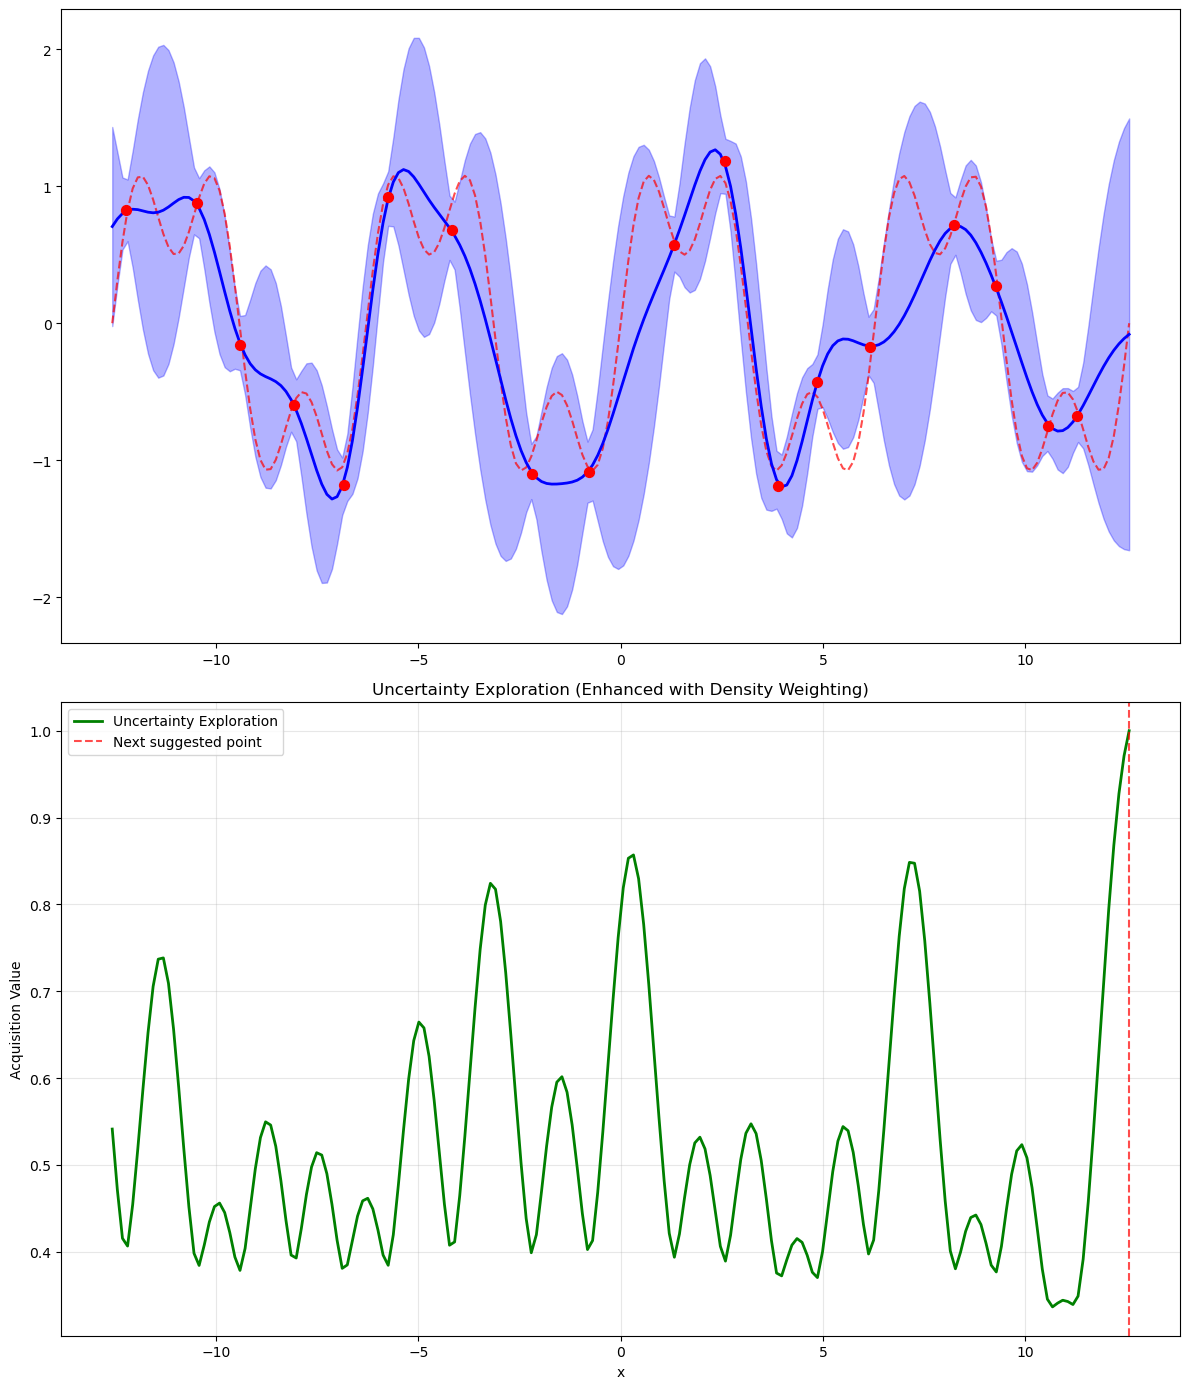

In [7]:
sampler_ue.plot_results(acquisition_func='UE')

In [8]:
#### Reset and try with Pure Uncertainty Exploration
sampler_ue = GPSinusoidalSampler(bounds=(-bound_weight*np.pi, bound_weight*np.pi), noise_level=0.1)
print("\n" + "=" * 60)
print("UNCERTAINTY EXPLORATION")
print("=" * 60)
sampler_ue.run_optimization(n_iterations=set_iteration, acquisition_func='UE', initial_samples=3)



UNCERTAINTY EXPLORATION
Running GP optimization with UE acquisition function...
Enhanced with uncertainty and sample density prioritization
Initial sample 1: x=-5.875, y=1.058
Initial sample 2: x=-10.844, y=0.574
Initial sample 3: x=9.268, y=0.488
Iteration 1: x=2.907, y=0.658


/usr/lib/python3/dist-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iteration 2: x=-2.584, y=-1.111
Iteration 3: x=0.310, y=0.736
Iteration 4: x=5.332, y=-0.821
Iteration 5: x=-7.890, y=-0.222


/usr/lib/python3/dist-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iteration 6: x=12.186, y=-0.833
Iteration 7: x=-1.346, y=-0.573
Iteration 8: x=-12.522, y=-0.036
Iteration 9: x=7.453, y=0.832
Iteration 10: x=1.627, y=0.411
Iteration 11: x=10.474, y=-0.830
Iteration 12: x=-9.835, y=0.813
Iteration 13: x=-3.741, y=1.048
Iteration 14: x=-11.754, y=1.199
Iteration 15: x=11.600, y=-0.901
Iteration 16: x=-4.686, y=0.431
Iteration 17: x=-8.865, y=-1.022
Iteration 18: x=-1.009, y=-0.958
Iteration 19: x=-0.341, y=-0.683
Iteration 20: x=6.398, y=0.364
Iteration 21: x=-6.637, y=-0.739
Iteration 22: x=8.484, y=1.031
Iteration 23: x=-1.958, y=-0.590
Iteration 24: x=4.879, y=-0.541
Iteration 25: x=1.304, y=0.582

Best found: x=-11.754, y=1.199
True optimum: x=1.571, y=0.500


Y predict :  [-0.08400555  0.09961138  0.32320098  0.56557376  0.79974793  0.99776307
  1.13616364  1.20077727  1.18956655  1.11287059  0.99107845  0.85042785
  0.71798954  0.61690616  0.56268356  0.5609544   0.606815    0.68565653
  0.77534544  0.84956036  0.8819804   0.85082505  0.74303794  0.5572969
  0.30512034  0.00965232 -0.29781165 -0.58297293 -0.81434944 -0.96857653
 -1.03410538 -1.01259802 -0.91787485 -0.77283984 -0.60522324 -0.44312268
 -0.31117047 -0.22779469 -0.20363075 -0.24084502 -0.3330586  -0.46570962
 -0.61696378 -0.75950382 -0.86353567 -0.90106412 -0.85097362 -0.70389973
 -0.46555435 -0.15728629  0.18673228  0.52536658  0.81815814  1.03288523
  1.15118813  1.17099799  1.10546972  0.97908684  0.82224068  0.66571334
  0.53615722  0.45308286  0.4273169   0.46057995  0.54581782  0.66810857
  0.80618851  0.93473358  1.02742758  1.06059217  1.01687454  0.88832541
  0.67823124  0.40127739  0.08192947 -0.24876851 -0.55752929 -0.81366297
 -0.99368539 -1.08492683 -1.08746516 -1

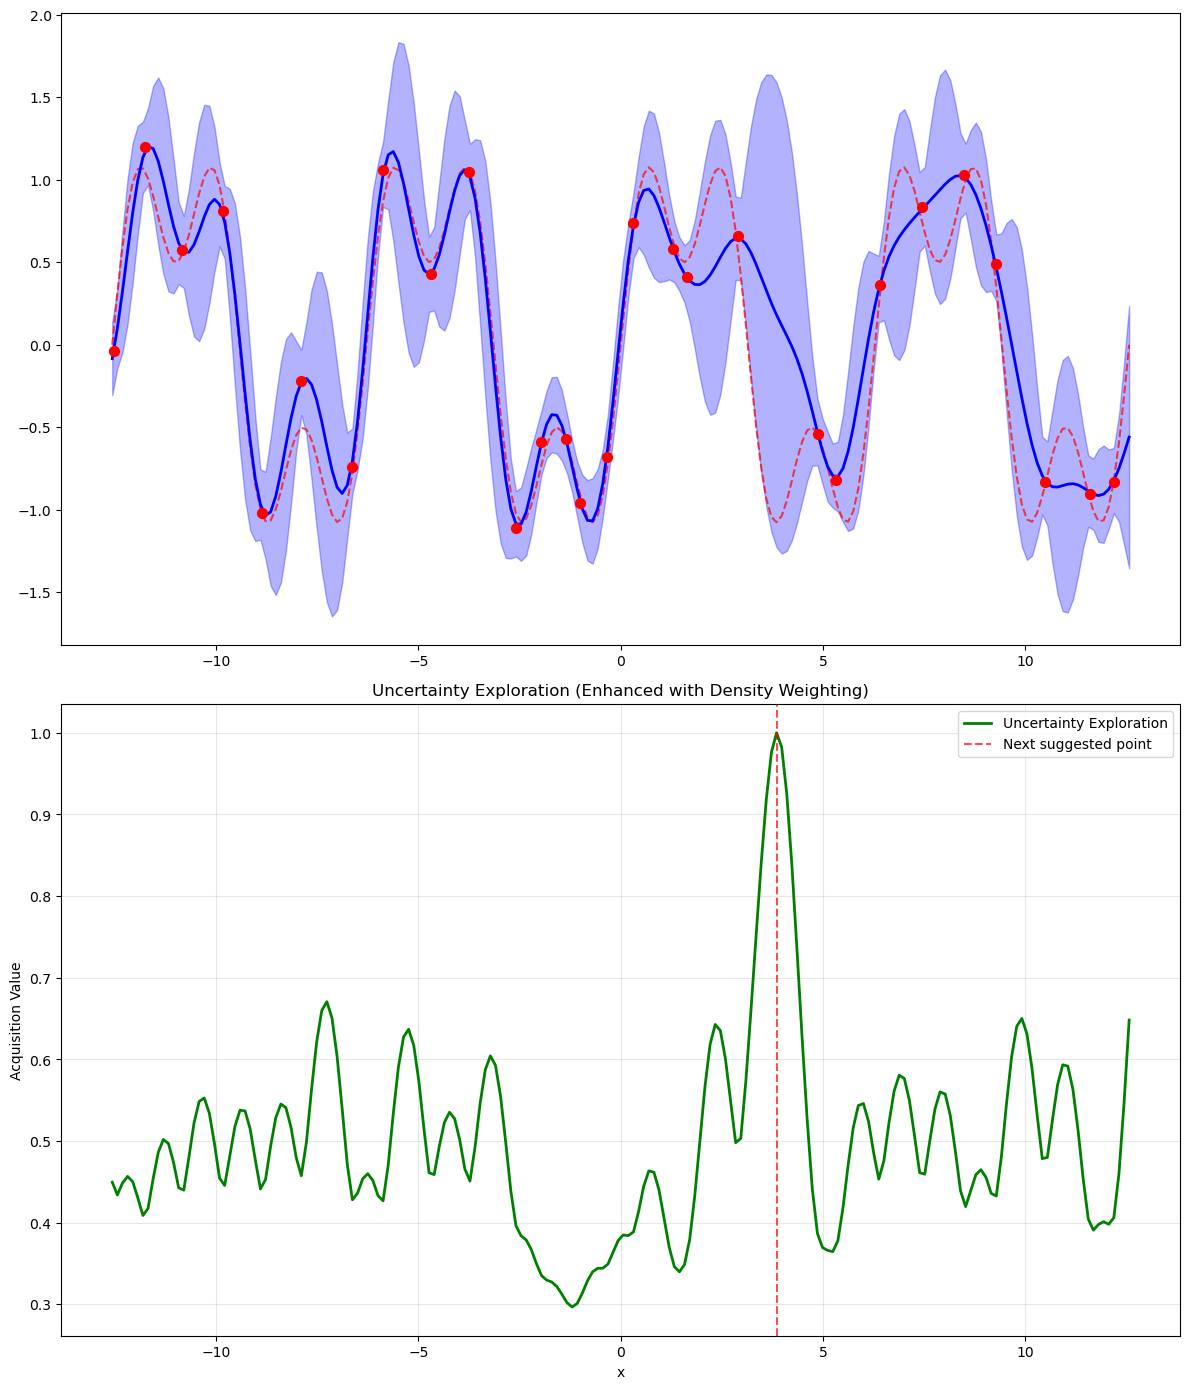

In [9]:
sampler_ue.plot_results(acquisition_func='UE')


UNCERTAINTY EXPLORATION - EVOLUTION SNAPSHOTS


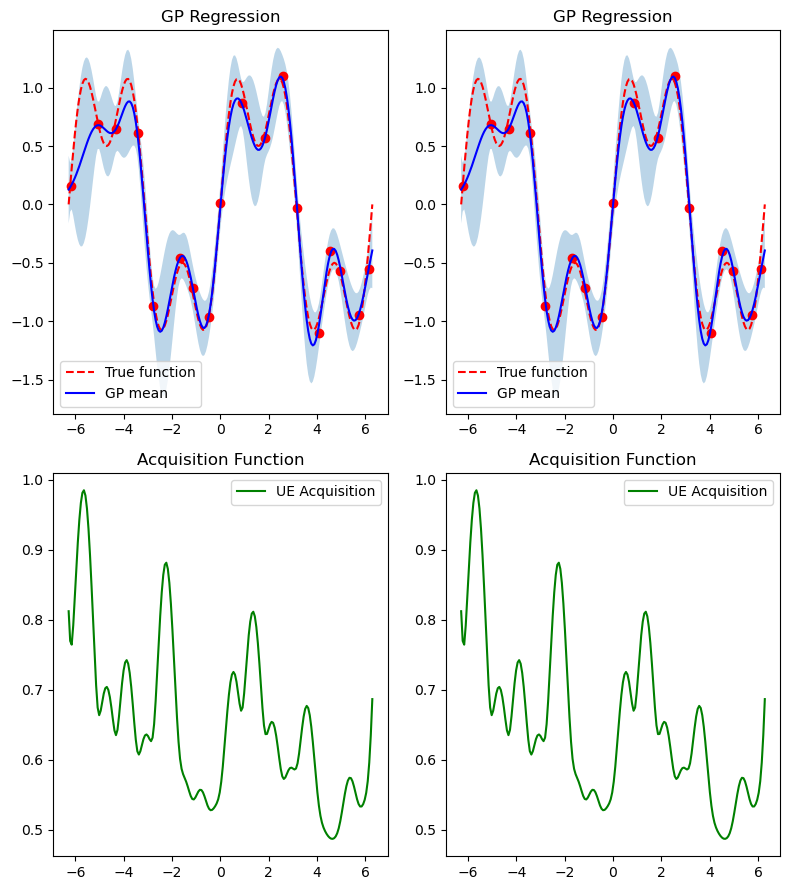

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from scipy.optimize import minimize
from scipy.stats import norm

class GPSinusoidalSampler:
    def __init__(self, bounds=(-2*np.pi, 2*np.pi), noise_level=0.1):
        self.bounds = bounds
        self.noise_level = noise_level
        self.true_function = lambda x: np.sin(x) + 0.5 * np.sin(3 * x)
        kernel = C(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-2, 1e2))
        self.gp = GaussianProcessRegressor(kernel=kernel, alpha=noise_level**2, n_restarts_optimizer=10, random_state=42)
        self.X_observed = np.empty((0, 1))
        self.y_observed = np.array([])
        self.snapshots = []

    def sample_function(self, x):
        return self.true_function(x) + np.random.normal(0, self.noise_level, x.shape)

    def add_observation(self, x, y=None):
        if y is None:
            y = self.sample_function(np.array([x]))[0]
        self.X_observed = np.vstack([self.X_observed, [[x]]])
        self.y_observed = np.append(self.y_observed, y)
        self.gp.fit(self.X_observed, self.y_observed)

    def sample_density_weight(self, X, bandwidth=0.5):
        if len(self.X_observed) == 0:
            return np.ones(X.shape[0])
        weights = np.array([1.0 / (1.0 + np.sum(np.exp(-((self.X_observed.flatten() - x) ** 2) / (2 * bandwidth**2)))) for x in X])
        return weights

    def uncertainty_exploration(self, X, density_weight=0.7, uncertainty_weight=0.3):
        _, sigma = self.gp.predict(X.reshape(-1, 1), return_std=True)
        density_weights = self.sample_density_weight(X)
        sigma_norm = sigma / (np.max(sigma) + 1e-9)
        density_norm = density_weights / (np.max(density_weights) + 1e-9)
        return uncertainty_weight * sigma_norm + density_weight * density_norm

    def expected_improvement(self, X, xi=0.01, density_boost=2.0):
        mu, sigma = self.gp.predict(X.reshape(-1, 1), return_std=True)
        f_best = np.max(self.y_observed)
        sigma = np.maximum(sigma, 1e-9)
        improvement = mu.flatten() - f_best - xi
        Z = improvement / sigma
        ei = improvement * norm.cdf(Z) + sigma * norm.pdf(Z)
        density_weights = self.sample_density_weight(X)
        return ei * (1.0 + density_boost * density_weights)

    def upper_confidence_bound(self, X, kappa=2.0, density_boost=1.5):
        mu, sigma = self.gp.predict(X.reshape(-1, 1), return_std=True)
        density_weights = self.sample_density_weight(X)
        return mu.flatten() + kappa * sigma.flatten() * (1.0 + density_boost * density_weights)

    def optimize_acquisition(self, acquisition_func='EI', n_restarts=10):
        def objective(x):
            X = np.array([x])
            if acquisition_func == 'EI':
                return -self.expected_improvement(X)[0]
            elif acquisition_func == 'UCB':
                return -self.upper_confidence_bound(X)[0]
            else:
                return -self.uncertainty_exploration(X)[0]

        best_x, best_val = None, float('inf')
        for _ in range(n_restarts):
            x0 = np.random.uniform(self.bounds[0], self.bounds[1])
            result = minimize(objective, x0, bounds=[self.bounds], method='L-BFGS-B')
            if result.fun < best_val:
                best_val, best_x = result.fun, result.x[0]
        return best_x

    def save_snapshot(self, iteration, acquisition_func):
        X_test = np.linspace(self.bounds[0], self.bounds[1], 200)
        y_pred, y_std = self.gp.predict(X_test.reshape(-1, 1), return_std=True)
        acq_func = {'EI': self.expected_improvement, 'UCB': self.upper_confidence_bound, 'UE': self.uncertainty_exploration}[acquisition_func]
        acq_values = acq_func(X_test)
        snapshot = {'iteration': iteration, 'X_test': X_test, 'y_pred': y_pred, 'y_std': y_std, 'acq_values': acq_values, 'X_observed': self.X_observed.copy(), 'y_observed': self.y_observed.copy()}
        self.snapshots.append(snapshot)

    def run_optimization(self, n_iterations=10, acquisition_func='EI', initial_samples=3, snapshot_iterations=None):
        if snapshot_iterations is None:
            snapshot_iterations = [max(1, n_iterations // 3), max(2, 2 * n_iterations // 3)]
        for _ in range(initial_samples):
            self.add_observation(np.random.uniform(self.bounds[0], self.bounds[1]))
        for i in range(n_iterations):
            x_next = self.optimize_acquisition(acquisition_func)
            self.add_observation(x_next)
            if (i + 1) in snapshot_iterations:
                self.save_snapshot(i + 1, acquisition_func)
        best_idx = np.argmax(self.y_observed)
        return self.X_observed[best_idx, 0], self.y_observed[best_idx]

    def plot_snapshots_and_final(self, acquisition_func='EI'):
        X_test = np.linspace(self.bounds[0], self.bounds[1], 200)
        y_true = self.true_function(X_test)
        y_pred, y_std = self.gp.predict(X_test.reshape(-1, 1), return_std=True)
        acq_func = {'EI': self.expected_improvement, 'UCB': self.upper_confidence_bound, 'UE': self.uncertainty_exploration}[acquisition_func]
        acq_values = acq_func(X_test)
        density_weights = self.sample_density_weight(X_test)
        fig, axes = plt.subplots(2, 2, figsize=(8, 9))
        axes[0,0].plot(X_test, y_true, 'r--', label='True function')
        axes[0,0].plot(X_test, y_pred, 'b-', label='GP mean')
        axes[0,0].fill_between(X_test, y_pred - 2 * y_std, y_pred + 2 * y_std, alpha=0.3)
        axes[0,0].scatter(self.X_observed, self.y_observed, c='red')
        axes[0,0].set_title('GP Regression')
        axes[0,0].legend()
        axes[1,0].plot(X_test, acq_values, 'g-', label=f'{acquisition_func} Acquisition')
        axes[1,0].set_title('Acquisition Function')
        axes[1,0].legend()
        
        axes[0,1].plot(X_test, y_true, 'r--', label='True function')
        axes[0,1].plot(X_test, y_pred, 'b-', label='GP mean')
        axes[0,1].fill_between(X_test, y_pred - 2 * y_std, y_pred + 2 * y_std, alpha=0.3)
        axes[0,1].scatter(self.X_observed, self.y_observed, c='red')
        axes[0,1].set_title('GP Regression')
        axes[0,1].legend()
        axes[1,1].plot(X_test, acq_values, 'g-', label=f'{acquisition_func} Acquisition')
        axes[1,1].set_title('Acquisition Function')
        axes[1,1].legend()
        
        #axes[2].plot(X_test, y_std, 'purple', label='GP Std Dev')
        #axes[2].set_ylabel('Uncertainty')
        #ax_twin = axes[2].twinx()
        #ax_twin.plot(X_test, density_weights, 'orange', label='Density Weight')
        #axes[2].set_title('Uncertainty & Sample Density')
        #axes[2].legend()
        plt.tight_layout()
        plt.show()



# Example usage
if __name__ == "__main__":
   
    ### Reset and try with Pure Uncertainty Exploration
    sampler_ue = GPSinusoidalSampler(bounds=(-2*np.pi, 2*np.pi), noise_level=0.1)
    print("\n" + "=" * 60)
    print("UNCERTAINTY EXPLORATION - EVOLUTION SNAPSHOTS")
    print("=" * 60)
    sampler_ue.run_optimization(n_iterations=15, acquisition_func='UE', initial_samples=3,
                              snapshot_iterations=[5, 10])
    sampler_ue.plot_snapshots_and_final(acquisition_func='UE')

DEMONSTRATION 1: ENHANCED EXPECTED IMPROVEMENT
Running GP optimization with EI acquisition function...
Enhanced with uncertainty and sample density prioritization
Saving snapshots at iterations: [5, 10, 15]
Initial sample 1: x=-1.577, y=-0.611
Initial sample 2: x=-4.323, y=0.761
Initial sample 3: x=-5.553, y=1.102
Iteration 1: x=-6.283, y=0.101


/usr/lib/python3/dist-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iteration 2: x=-5.092, y=0.732
Iteration 3: x=-3.691, y=0.969
Iteration 4: x=-2.996, y=-0.336
Iteration 5: x=5.301, y=-0.841
  -> Snapshot saved at iteration 5
Iteration 6: x=2.436, y=1.165
Iteration 7: x=1.935, y=0.780
Iteration 8: x=3.037, y=0.218
Iteration 9: x=0.272, y=0.627
Iteration 10: x=2.332, y=1.188
  -> Snapshot saved at iteration 10
Iteration 11: x=-0.380, y=-0.808
Iteration 12: x=-3.947, y=1.051
Iteration 13: x=0.837, y=0.870
Iteration 14: x=2.361, y=0.974
Iteration 15: x=4.171, y=-0.876
  -> Snapshot saved at iteration 15

Best found: x=2.332, y=1.188
True optimum: x=1.571, y=0.500

Evolution Summary:
Snapshot 1 (Iter 5): 8 observations, Best y = 1.102
Snapshot 2 (Iter 10): 13 observations, Best y = 1.188
Final state: 18 observations, Best y = 1.188
True optimum: y = 0.500 at x = 1.571


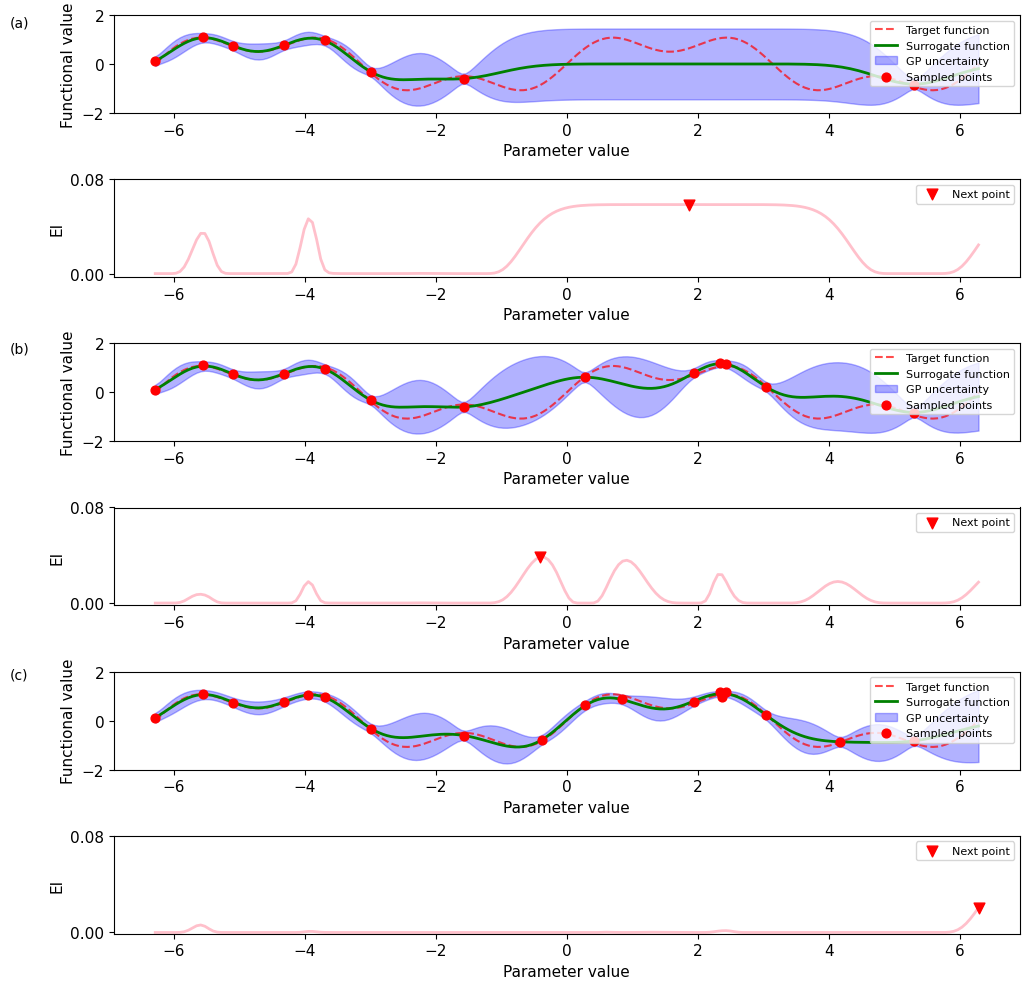

In [79]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from scipy.optimize import minimize
from scipy.stats import norm

class GPSinusoidalSampler:
    def __init__(self, bounds=(-2*np.pi, 2*np.pi), noise_level=0.1):
        """
        Initialize the GP sampler for a sinusoidal function.
        
        Args:
            bounds: tuple of (min, max) for the sampling domain
            noise_level: noise level for observations
        """
        self.bounds = bounds
        self.noise_level = noise_level
        
        # Define the true sinusoidal function
        self.true_function = lambda x: np.sin(x) + 0.5 * np.sin(3*x)
        
        # Initialize GP with RBF kernel
        kernel = C(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-2, 1e2))
        self.gp = GaussianProcessRegressor(
            kernel=kernel,
            alpha=noise_level**2,
            n_restarts_optimizer=10,
            random_state=42
        )
        
        # Storage for observations
        self.X_observed = np.array([]).reshape(0, 1)
        self.y_observed = np.array([])
        
        # Storage for snapshots
        self.snapshots = []
        
    def sample_function(self, x):
        """Sample the true function with noise."""
        return self.true_function(x) + np.random.normal(0, self.noise_level, x.shape)
    
    def sample_density_weight(self, X, bandwidth=0.5):
        """
        Calculate sample density weights - higher weights for lower density areas.
        
        Args:
            X: points to evaluate
            bandwidth: bandwidth for density estimation
        """
        if len(self.X_observed) == 0:
            return np.ones(X.shape[0])
        
        # Calculate distance-based density for each point
        weights = np.ones(X.shape[0])
        
        for i, x in enumerate(X):
            # Calculate distances to all observed points
            distances = np.abs(self.X_observed.flatten() - x)
            
            # Use exponential decay to weight nearby samples more heavily
            density = np.sum(np.exp(-distances**2 / (2 * bandwidth**2)))
            
            # Invert density to prioritize low-density areas
            weights[i] = 1.0 / (1.0 + density)
        
        return weights
    
    def uncertainty_exploration(self, X, density_weight=0.7, uncertainty_weight=0.3):
        """
        Pure uncertainty-based exploration with sample density weighting.
        
        Args:
            X: points to evaluate
            density_weight: weight for sample density component
            uncertainty_weight: weight for GP uncertainty component
        """
        if len(self.X_observed) == 0:
            return np.ones(X.shape[0])
        
        # Get GP uncertainty (standard deviation)
        _, sigma = self.gp.predict(X.reshape(-1, 1), return_std=True)
        sigma = sigma.flatten()
        
        # Get sample density weights
        density_weights = self.sample_density_weight(X)
        
        # Normalize both components
        sigma_norm = sigma / (np.max(sigma) + 1e-9)
        density_norm = density_weights / (np.max(density_weights) + 1e-9)
        
        # Combine uncertainty and density
        acquisition = uncertainty_weight * sigma_norm + density_weight * density_norm
        
        return acquisition
    
    def expected_improvement(self, X, xi=0.01, density_boost=2.0):
        """
        Enhanced Expected Improvement with sample density weighting.
        
        Args:
            X: points to evaluate
            xi: exploration parameter
            density_boost: multiplier for low-density areas
        """
        if len(self.X_observed) == 0:
            return np.ones(X.shape[0])
        
        mu, sigma = self.gp.predict(X.reshape(-1, 1), return_std=True)
        mu = mu.flatten()
        sigma = sigma.flatten()
        
        # Current best observation
        f_best = np.max(self.y_observed)
        
        # Handle numerical stability
        sigma = np.maximum(sigma, 1e-9)
        
        # Calculate standard EI
        improvement = mu - f_best - xi
        Z = improvement / sigma
        ei = improvement * norm.cdf(Z) + sigma * norm.pdf(Z)
        
        # Add sample density weighting
        density_weights = self.sample_density_weight(X)
        
        # Boost EI in low-density areas
        ei_enhanced = ei * (1.0 + density_boost * density_weights)
        
        return ei_enhanced
    
    def upper_confidence_bound(self, X, kappa=2.0, density_boost=1.5):
        """
        Enhanced Upper Confidence Bound with sample density weighting.
        
        Args:
            X: points to evaluate
            kappa: exploration parameter
            density_boost: multiplier for low-density areas
        """
        if len(self.X_observed) == 0:
            return np.ones(X.shape[0])
        
        mu, sigma = self.gp.predict(X.reshape(-1, 1), return_std=True)
        ucb = mu.flatten() + kappa * sigma.flatten()
        
        # Add sample density weighting
        density_weights = self.sample_density_weight(X)
        
        # Boost UCB in low-density areas
        ucb_enhanced = ucb + density_boost * sigma.flatten() * density_weights
        
        return ucb_enhanced
    
    def optimize_acquisition(self, acquisition_func='EI', n_restarts=10):
        """
        Find the point that maximizes the acquisition function.
        
        Args:
            acquisition_func: 'EI', 'UCB', or 'UE' (Uncertainty Exploration)
            n_restarts: number of random restarts for optimization
        """
        def objective(x):
            if acquisition_func == 'EI':
                return -self.expected_improvement(np.array([x]))[0]
            elif acquisition_func == 'UCB':
                return -self.upper_confidence_bound(np.array([x]))[0]
            else:  # UE - Uncertainty Exploration
                return -self.uncertainty_exploration(np.array([x]))[0]
        
        best_x = None
        best_val = float('inf')
        
        # Try multiple random starting points
        for _ in range(n_restarts):
            x0 = np.random.uniform(self.bounds[0], self.bounds[1])
            result = minimize(objective, x0, bounds=[self.bounds], method='L-BFGS-B')
            
            if result.fun < best_val:
                best_val = result.fun
                best_x = result.x[0]
        
        return best_x
    
    def add_observation(self, x, y=None):
        """Add a new observation to the dataset."""
        if y is None:
            y = self.sample_function(np.array([x]))[0]
        
        self.X_observed = np.vstack([self.X_observed, [[x]]])
        self.y_observed = np.append(self.y_observed, y)
        
        # Refit the GP
        if len(self.X_observed) > 0:
            self.gp.fit(self.X_observed, self.y_observed)
    
    def save_snapshot(self, iteration, acquisition_func):
        """Save a snapshot of the current state for visualization."""
        if len(self.X_observed) > 0:
            # Create test points for evaluation
            X_test = np.linspace(self.bounds[0], self.bounds[1], 200)
            
            # GP predictions
            y_pred, y_std = self.gp.predict(X_test.reshape(-1, 1), return_std=True)
            
            # Acquisition function values
            if acquisition_func == 'EI':
                acq_values = self.expected_improvement(X_test)
                acq_name = "Enhanced Expected Improvement"
            elif acquisition_func == 'UCB':
                acq_values = self.upper_confidence_bound(X_test)
                acq_name = "Enhanced Upper Confidence Bound"
            else:  # UE
                acq_values = self.uncertainty_exploration(X_test)
                acq_name = "Uncertainty Exploration"
            
            snapshot = {
                'iteration': iteration,
                'X_test': X_test,
                'y_pred': y_pred,
                'y_std': y_std,
                'acq_values': acq_values,
                'acq_name': acq_name,
                'X_observed': self.X_observed.copy(),
                'y_observed': self.y_observed.copy()
            }
            self.snapshots.append(snapshot)
    
    def run_optimization(self, n_iterations=10, acquisition_func='EI', initial_samples=3, snapshot_iterations=None):
        """
        Run the complete optimization loop with snapshots.
        
        Args:
            n_iterations: number of optimization iterations
            acquisition_func: 'EI', 'UCB', or 'UE' (Uncertainty Exploration)
            initial_samples: number of random initial samples
            snapshot_iterations: list of iterations to save snapshots (e.g., [3, 8])
        """
        if snapshot_iterations is None:
            # Default snapshots at 1/3 and 2/3 of iterations
            snapshot_iterations = [max(1, n_iterations // 3), max(2, 2 * n_iterations // 3)]
        
        print(f"Running GP optimization with {acquisition_func} acquisition function...")
        print("Enhanced with uncertainty and sample density prioritization")
        print(f"Saving snapshots at iterations: {snapshot_iterations}")
        
        # Clear previous snapshots
        self.snapshots = []
        
        # Initial random sampling
        for i in range(initial_samples):
            x = np.random.uniform(self.bounds[0], self.bounds[1])
            self.add_observation(x)
            print(f"Initial sample {i+1}: x={x:.3f}, y={self.y_observed[-1]:.3f}")
        
        # Optimization loop
        for i in range(n_iterations):
            # Find next point to sample
            x_next = self.optimize_acquisition(acquisition_func)
            
            # Sample the function
            self.add_observation(x_next)
            
            print(f"Iteration {i+1}: x={x_next:.3f}, y={self.y_observed[-1]:.3f}")
            
            # Save snapshot if this is a snapshot iteration
            if (i + 1) in snapshot_iterations:
                self.save_snapshot(i + 1, acquisition_func)
                print(f"  -> Snapshot saved at iteration {i+1}")
        
        # Find the best observation
        best_idx = np.argmax(self.y_observed)
        best_x = self.X_observed[best_idx, 0]
        best_y = self.y_observed[best_idx]
        
        print(f"\nBest found: x={best_x:.3f}, y={best_y:.3f}")
        print(f"True optimum: x={np.pi/2:.3f}, y={self.true_function(np.pi/2):.3f}")
    
    def plot_snapshots_and_final(self, acquisition_func='EI'):
        """Plot snapshots and final state in a 2x2 grid."""
        if len(self.snapshots) < 2:
            print("Need at least 2 snapshots to create the plot!")
            return
        
        # Create test points for final state
        X_test = np.linspace(self.bounds[0], self.bounds[1], 200)
        y_true = self.true_function(X_test)
        
        # Create 2x2 subplot grid
        fig, axes = plt.subplots(6, 1, figsize=(10, 10))
        #fig.suptitle(f'GP Optimization Evolution with {self.snapshots[0]["acq_name"]}', 
        #             fontsize=16, fontweight='bold')
        
        # Helper function to plot GP state
        def plot_gp_state(ax, X_test, y_true, y_pred, y_std, X_obs, y_obs, title, iteration):
            ax.plot(X_test, y_true, 'r--', label='Target function', alpha=0.7, linewidth=1.5)
            ax.plot(X_test, y_pred, 'g-', label='Surrogate function', linewidth=2)
            ax.fill_between(X_test, y_pred - 2*y_std, y_pred + 2*y_std,
                           alpha=0.3, color='blue', label='GP uncertainty')
            ax.scatter(X_obs.flatten(), y_obs, c='red', s=40, zorder=5, label='Sampled points')
            
            ### Highlight best observation
            #if len(y_obs) > 0:
            #    best_idx = np.argmax(y_obs)
            #    ax.scatter(X_obs[best_idx], y_obs[best_idx], c='gold', s=80, 
            #              marker='*', zorder=6, label='Best')
            
            #ax.set_title(f'{title} (Iteration {iteration})', fontweight='bold')
            ax.set_xlabel('Parameter value', fontsize=11)
            ax.set_xticks([-6,-4,-2,0,2,4,6])
            ax.set_ylabel('Functional value', fontsize=11)
            ax.set_yticks([-2, 0, 2])
            ax.tick_params(axis='both', which='major', labelsize=11)
            ax.legend(loc="upper right",fontsize=8)
            #ax.grid(True, alpha=0.3)
        
        # Helper function to plot acquisition function
        def plot_acquisition(ax, X_test, acq_values, acq_name, iteration):
            ax.plot(X_test, acq_values, 'pink', linewidth=2)
            
            # Mark the next suggested point
            if len(acq_values) > 0:
                next_x = X_test[np.argmax(acq_values)]
                next_y = np.max(acq_values)
                ax.scatter(next_x, next_y, color='red', s=60, marker='v', 
                          zorder=5, label='Next point')
                ax.legend(loc="upper right",fontsize=8)
            
            #ax.set_title(f'{acq_name} (Iteration {iteration})', fontweight='bold')
            ax.set_xlabel('Parameter value', fontsize=11)
            ax.set_xticks([-6,-4,-2,0,2,4,6])
            ax.set_ylabel('EI', fontsize=11)
            ax.set_yticks([0, 0.08])
            ax.tick_params(axis='both', which='major', labelsize=11)
            #ax.grid(True, alpha=0.3)
        
        # Plot first snapshot (top row)
        snapshot1 = self.snapshots[0]
        plot_gp_state(axes[0], snapshot1['X_test'], y_true, snapshot1['y_pred'], 
                     snapshot1['y_std'], snapshot1['X_observed'], snapshot1['y_observed'],
                     'GP Model', snapshot1['iteration'])
        
        plot_acquisition(axes[1], snapshot1['X_test'], snapshot1['acq_values'],
                        snapshot1['acq_name'], snapshot1['iteration'])
        
        # Plot second snapshot (bottom row)
        snapshot2 = self.snapshots[1]
        plot_gp_state(axes[2], snapshot2['X_test'], y_true, snapshot2['y_pred'], 
                     snapshot2['y_std'], snapshot2['X_observed'], snapshot2['y_observed'],
                     'GP Model', snapshot2['iteration'])
        
        plot_acquisition(axes[3], snapshot2['X_test'], snapshot2['acq_values'],
                        snapshot2['acq_name'], snapshot2['iteration'])
        
        snapshot3 = self.snapshots[2]
        plot_gp_state(axes[4], snapshot3['X_test'], y_true, snapshot3['y_pred'], 
                     snapshot3['y_std'], snapshot3['X_observed'], snapshot3['y_observed'],
                     'GP Model', snapshot3['iteration'])
        
        plot_acquisition(axes[5], snapshot3['X_test'], snapshot3['acq_values'],
                        snapshot3['acq_name'], snapshot3['iteration'])
        
        plt.tight_layout()
        plt.text(-8.5,0.75, "(a)")
        plt.text(-8.5,0.48, "(b)")
        plt.text(-8.5,0.21, "(c)")
        plt.savefig("Bolfi_concept.png", dpi=400)
        
        # Print summary statistics
        print(f"\nEvolution Summary:")
        print(f"Snapshot 1 (Iter {snapshot1['iteration']}): {len(snapshot1['y_observed'])} observations, Best y = {np.max(snapshot1['y_observed']):.3f}")
        print(f"Snapshot 2 (Iter {snapshot2['iteration']}): {len(snapshot2['y_observed'])} observations, Best y = {np.max(snapshot2['y_observed']):.3f}")
        if len(self.y_observed) > 0:
            print(f"Final state: {len(self.y_observed)} observations, Best y = {np.max(self.y_observed):.3f}")
            print(f"True optimum: y = {self.true_function(np.pi/2):.3f} at x = {np.pi/2:.3f}")
    
    def plot_results(self, acquisition_func='EI'):
        """Plot the GP model, observations, acquisition function, and sample density."""
        if len(self.X_observed) == 0:
            print("No observations to plot!")
            return
        
        # Create test points
        X_test = np.linspace(self.bounds[0], self.bounds[1], 200).reshape(-1, 1)
        y_true = self.true_function(X_test.flatten())
        
        # GP predictions
        y_pred, y_std = self.gp.predict(X_test, return_std=True)
        
        # Acquisition function values
        if acquisition_func == 'EI':
            acq_values = self.expected_improvement(X_test.flatten())
            acq_name = "Enhanced Expected Improvement"
        elif acquisition_func == 'UCB':
            acq_values = self.upper_confidence_bound(X_test.flatten())
            acq_name = "Enhanced Upper Confidence Bound"
        else:  # UE
            acq_values = self.uncertainty_exploration(X_test.flatten())
            acq_name = "Uncertainty Exploration"
        
        # Sample density weights
        density_weights = self.sample_density_weight(X_test.flatten())
        
        # Create plots
        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12))
        
        # Plot 1: GP model and observations
        ax1.plot(X_test.flatten(), y_true, 'r--', label='Target function', alpha=0.7)
        ax1.plot(X_test.flatten(), y_pred, 'b-', label='Surrogate function', linewidth=2)
        ax1.fill_between(X_test.flatten(), y_pred - 2*y_std, y_pred + 2*y_std,
                        alpha=0.3, color='blue', label='GP uncertainty')
        ax1.scatter(self.X_observed.flatten(), self.y_observed, 
                   c='red', s=50, zorder=5, label='Sample points')
        
        ### Highlight the best observation
        #best_idx = np.argmax(self.y_observed)
        #ax1.scatter(self.X_observed[best_idx], self.y_observed[best_idx],
        #           c='gold', s=100, marker='*', zorder=6, label='Best observation')
        
        ax1.set_xlabel('x')
        ax1.set_ylabel('y')
        ax1.set_title('Gaussian Process Regression with Uncertainty & Density-Aware Sampling')
        #ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Plot 2: Acquisition function
        ax2.plot(X_test.flatten(), acq_values, 'g-', linewidth=2, label=acq_name)
        ax2.set_xlabel('x')
        ax2.set_ylabel('Acquisition Value')
        ax2.set_title(f'{acq_name} (Enhanced with Density Weighting)')
        ax2.grid(True, alpha=0.3)
        
        # Mark the next suggested point
        if len(acq_values) > 0:
            next_x = X_test.flatten()[np.argmax(acq_values)]
            ax2.axvline(x=next_x, color='red', linestyle='--', alpha=0.7, 
                       label='Next suggested point')
            #ax2.legend()
        
        # Plot 3: Sample density and uncertainty
        ax3_twin = ax3.twinx()
        
        # Plot uncertainty (std deviation)
        line1 = ax3.plot(X_test.flatten(), y_std, 'purple', linewidth=2, 
                        label='GP Uncertainty (σ)', alpha=0.8)
        ax3.set_ylabel('GP Uncertainty (σ)', color='purple')
        ax3.tick_params(axis='y', labelcolor='purple')
        
        # Plot sample density weights
        line2 = ax3_twin.plot(X_test.flatten(), density_weights, 'orange', linewidth=2, 
                             label='Low Density Weight', alpha=0.8)
        ax3_twin.set_ylabel('Sample Density Weight', color='orange')
        ax3_twin.tick_params(axis='y', labelcolor='orange')
        
        # Add vertical lines for observed points
        for x_obs in self.X_observed.flatten():
            ax3.axvline(x=x_obs, color='red', alpha=0.3, linestyle='-', linewidth=1)
        
        ax3.set_xlabel('x')
        ax3.set_title('GP Uncertainty vs Sample Density')
        ax3.grid(True, alpha=0.3)
        
        # Combine legends
        lines1, labels1 = ax3.get_legend_handles_labels()
        lines2, labels2 = ax3_twin.get_legend_handles_labels()
        ax3.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
        
        plt.tight_layout()
        plt.show()
    
    def compare_acquisition_functions(self, n_iterations=15, initial_samples=3):
        """Compare all three acquisition functions side by side."""
        acquisition_funcs = ['EI', 'UCB', 'UE']
        samplers = {}
        
        print("=" * 80)
        print("COMPARING ACQUISITION FUNCTIONS")
        print("=" * 80)
        
        # Run optimization for each acquisition function
        for acq_func in acquisition_funcs:
            print(f"\n>>> Running {acq_func} optimization...")
            sampler = GPSinusoidalSampler(bounds=self.bounds, noise_level=self.noise_level)
            sampler.run_optimization(n_iterations=n_iterations, 
                                   acquisition_func=acq_func, 
                                   initial_samples=initial_samples,
                                   snapshot_iterations=[n_iterations//3, 2*n_iterations//3])
            samplers[acq_func] = sampler
        
        # Create comparison plot
        fig, axes = plt.subplots(3, 2, figsize=(16, 18))
        fig.suptitle('Acquisition Function Comparison', fontsize=16, fontweight='bold')
        
        X_test = np.linspace(self.bounds[0], self.bounds[1], 200)
        y_true = self.true_function(X_test)
        
        for i, acq_func in enumerate(acquisition_funcs):
            sampler = samplers[acq_func]
            
            # GP model plot
            ax1 = axes[i, 0]
            if len(sampler.X_observed) > 0:
                y_pred, y_std = sampler.gp.predict(X_test.reshape(-1, 1), return_std=True)
                
                ax1.plot(X_test, y_true, 'r--', label='Target function', alpha=0.7)
                ax1.plot(X_test, y_pred, 'b-', label='Surrogate function', linewidth=2)
                ax1.fill_between(X_test, y_pred - 2*y_std, y_pred + 2*y_std,
                               alpha=0.3, color='blue', label='GP uncertainty')
                ax1.scatter(sampler.X_observed.flatten(), sampler.y_observed, 
                           c='red', s=40, zorder=5, label='sampled points')
                
                #### Highlight best
                #best_idx = np.argmax(sampler.y_observed)
                #ax1.scatter(sampler.X_observed[best_idx], sampler.y_observed[best_idx],
                #           c='gold', s=80, marker='*', zorder=6, label='Best')
            
            ax1.set_title(f'{acq_func} - GP Model (Final State)')
            ax1.set_xlabel('x')
            ax1.set_ylabel('y')
            ax1.legend(fontsize=8)
            ax1.grid(True, alpha=0.3)
            
            # Acquisition function plot
            ax2 = axes[i, 1]
            if len(sampler.X_observed) > 0:
                if acq_func == 'EI':
                    acq_values = sampler.expected_improvement(X_test)
                    acq_name = "Enhanced Expected Improvement"
                elif acq_func == 'UCB':
                    acq_values = sampler.upper_confidence_bound(X_test)
                    acq_name = "Enhanced Upper Confidence Bound"
                else:  # UE
                    acq_values = sampler.uncertainty_exploration(X_test)
                    acq_name = "Uncertainty Exploration"
                
                ax2.plot(X_test, acq_values, 'g-', linewidth=2)
                
                # Mark observations
                for x_obs in sampler.X_observed.flatten():
                    ax2.axvline(x=x_obs, color='red', alpha=0.3, linestyle='-', linewidth=1)
            
            ax2.set_title(f'{acq_func} - Acquisition Function')
            ax2.set_xlabel('x')
            ax2.set_ylabel('Acquisition Value')
            ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Performance summary
        print("\n" + "=" * 80)
        print("PERFORMANCE SUMMARY")
        print("=" * 80)
        
        true_optimum = self.true_function(np.pi/2)
        
        for acq_func in acquisition_funcs:
            sampler = samplers[acq_func]
            if len(sampler.y_observed) > 0:
                best_y = np.max(sampler.y_observed)
                best_x = sampler.X_observed[np.argmax(sampler.y_observed), 0]
                regret = true_optimum - best_y
                
                print(f"{acq_func:3s}: Best = {best_y:.4f} at x = {best_x:.4f}, "
                      f"Regret = {regret:.4f}, Samples = {len(sampler.y_observed)}")
        
        print(f"True optimum: {true_optimum:.4f} at x = {np.pi/2:.4f}")


# Example usage and demonstration
if __name__ == "__main__":
    # Set random seed for reproducibility
    np.random.seed(42)
    
    # Create the sampler
    sampler = GPSinusoidalSampler(bounds=(-2*np.pi, 2*np.pi), noise_level=0.1)
    
    # Demonstration 1: Single optimization with snapshots
    print("=" * 60)
    print("DEMONSTRATION 1: ENHANCED EXPECTED IMPROVEMENT")
    print("=" * 60)
    sampler.run_optimization(n_iterations=15, acquisition_func='EI', initial_samples=3, 
                           snapshot_iterations=[5, 10, 15])
    sampler.plot_snapshots_and_final(acquisition_func='EI')
